In [1]:
import numpy as np
import matplotlib.pyplot as plt
from outlier_detection.Outliers import ZScoreOutlier, ESDOutlier
from forecast.TripleExponentialSmoothing import TripleExponentialSmoothing
from data_gen.GenerateData import ElectricityData
from sklearn.model_selection import TimeSeriesSplit
from tqdm import tqdm
from scipy.optimize import minimize

In [6]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5

In [2]:
def root_mean_square_error(x, y):
    """
    Simple Root Mean Square implementation.
    Shape of X and Y should be the same.

    :param x: list
    :param y: list
    :return: float
    """
    mse = np.square(np.subtract(x, y)).mean()
    rmse = np.sqrt(mse)
    return rmse


In [13]:
# Using TimeSeriesCV and scipy optimize to for hyper params tuning

In [8]:
def sc_optimize_params():
    def timeseriesCVscore(params, series, loss_function=root_mean_square_error, slen=24):
        """
            Returns error on CV

            params - vector of parameters for optimization
            series - dataset with timeseries
            slen - season length for Holt-Winters model
        """
        # errors array
        series = np.array(series)
        errors = []

        values = series
        alpha, beta, gamma = params

        # set the number of folds for cross-validation
        tscv = TimeSeriesSplit(n_splits=3)

        # iterating over folds, train model on each, forecast and calculate error
        for train, test in tscv.split(values):
            model = TripleExponentialSmoothing(ts=values[train], seasonality=24,
                                               alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
            model.triple_exponential_smoothing()

            predictions = model.forecast[-len(test):]
            actual = values[test]
            error = loss_function(predictions, actual)
            errors.append(error)

        return np.mean(np.array(errors))

    e = ElectricityData(2019, 1, 3, 730, 10, 30)
    d = e.compute()
    dates = d['dates']
    units = d['units']
    ts = units
    data = ts
    # initializing model parameters alpha, beta and gamma
    x = [0, 0, 0]

    # Minimizing the loss function
    opt = minimize(timeseriesCVscore, x0=x,
                   args=(data, root_mean_square_error),
                   method="TNC", bounds=((0, 1), (0, 1), (0, 1))
                   )

    # Take optimal values...
    alpha_final, beta_final, gamma_final = opt.x
    print(alpha_final, beta_final, gamma_final)

    n_preds = 15
    model = TripleExponentialSmoothing(ts, seasonality=int(len(ts)/3),
                                       alpha=alpha_final,
                                       beta=beta_final,
                                       gamma=gamma_final,
                                       n_preds=n_preds)
    forecast = model.triple_exponential_smoothing()
    print(forecast.shape)

    new_dates = dates[-1]

    ne = ElectricityData(new_dates.year, new_dates.day, new_dates.month, n_preds, 1, 10)
    ne = ne.compute()
    forecast_dates = np.append(np.array(dates), ne['dates'])

    esd = ESDOutlier(window=5)
    esd_out_index = esd.evaluate(forecast)
    forecast = np.append(ts, forecast[-n_preds:])
    z_outliers = ZScoreOutlier(forecast, 2)
    out_index = z_outliers.detect_outliers()
    print(out_index)
    plt.scatter(forecast_dates[esd_out_index], forecast[esd_out_index], marker='o', s=50, c='y')
    plt.scatter(forecast_dates[out_index], forecast[out_index], marker='*', s=50, c='g')
    plt.plot(forecast_dates, forecast, c='b')
    plt.plot(dates, units, c='r')
    plt.vlines(x=dates[-1], ymin=min(units) - 1, ymax=max(units) + 1, colors='black', linestyles='dashed')
    plt.show()
    print(forecast_dates.shape)


0.0 0.0 0.0
(745,)


[161, 163, 173, 176, 186, 188, 207, 285, 322, 351, 353, 525, 542, 577, 593, 607, 614, 616, 626, 636, 679, 687, 691, 729]


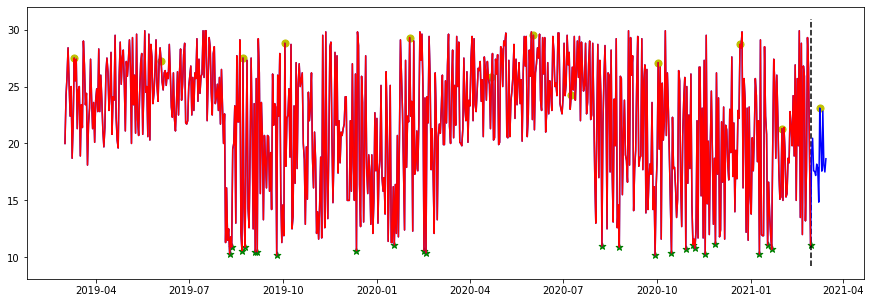

(745,)


In [9]:
sc_optimize_params()

# Looping over some values to optimize parameters

In [10]:
def main():
    e = ElectricityData(2019, 1, 3, 730, 10, 30)
    d = e.compute()
    dates = d['dates']
    units = d['units']
    ts = units
    d = {}
    best_tes = None
    min_rmse = float('inf')
    new_dates = dates[-1]
    n_preds = 15
    ne = ElectricityData(new_dates.year, new_dates.day, new_dates.month, n_preds, 1, 10)
    ne = ne.compute()
    forecast_dates = np.append(np.array(dates), ne['dates'])
    print(forecast_dates.shape)
    for season in tqdm(range(50, int(len(ts) / 2), 10)):
        for alpha in range(0, 10):
            alpha = alpha / 10
            for beta in range(0, 10):
                beta = beta / 10
                for gamma in range(0, 10):
                    gamma = gamma / 10
                    tes = TripleExponentialSmoothing(ts, season, alpha, beta, gamma, n_preds=15)
                    forecast = tes.triple_exponential_smoothing()
                    rmse_ = root_mean_square_error(forecast[:len(ts)], ts)
                    if rmse_ < min_rmse:
                        min_rmse = rmse_
                        best_tes = tes
                    d[rmse_] = (season, alpha, beta, gamma)

    forecast = best_tes.triple_exponential_smoothing()
    print(forecast.shape)
    print(forecast_dates.shape)

    esd = ESDOutlier(window=5)
    esd_out_index = esd.evaluate(forecast)
    z_outliers = ZScoreOutlier(forecast, 2)
    out_index = z_outliers.detect_outliers()
    print(out_index)
    plt.scatter(forecast_dates[esd_out_index], forecast[esd_out_index], marker='o', s=50, c='y')
    plt.scatter(forecast_dates[out_index], forecast[out_index], marker='*', s=50, c='g')
    plt.plot(forecast_dates, forecast, c='b')
    plt.plot(dates, units, c='r')
    plt.vlines(x=dates[-1], ymin=min(units) - 1, ymax=max(units) + 1, colors='black', linestyles='dashed')
    plt.show()

  0%|          | 0/32 [00:00<?, ?it/s]

(745,)


100%|██████████| 32/32 [00:53<00:00,  1.68s/it]


(745,)
(745,)


[153, 177, 189, 192, 196, 266, 285, 337, 357, 557, 580, 586, 596, 609, 629, 643, 663, 679, 681, 690, 727]


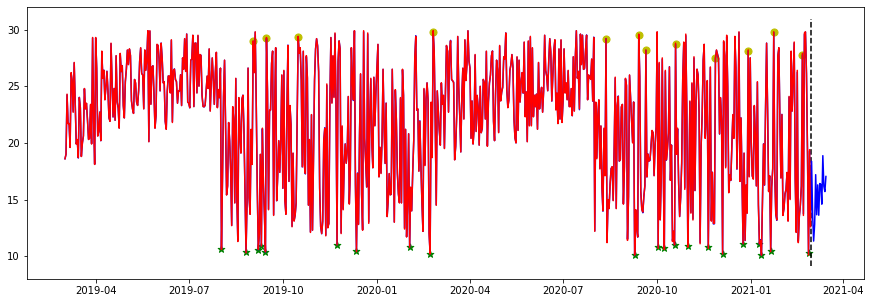

In [11]:
main()